<a href="https://colab.research.google.com/github/sbathwal1999/BDSN_Spark_Assignment/blob/main/BDSN_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Shubham Bathwal<br>
SID : A21031

The objective of the project is to predict the future flight fare and to identify the factors on which the price depends.

DATA COLLECTION AND METHODOLOGY<br>
Octoparse scraping tool was used to extract data from the website. Data was collected in two parts: one for economy class tickets and another for business class tickets. A total of 300261 distinct flight booking options was extracted from the site. Data was collected for 50 days, from February 11th to March 31st, 2022.
Data source was secondary data and was collected from Ease my trip website.

#Loading Data Files

Data is uploaded in zip format in the Github

In [1]:
#Downloading the file in the collab
!wget https://github.com/sbathwal1999/BDSN_Spark_Assignment/raw/main/flight.zip

--2022-03-05 13:39:21--  https://github.com/sbathwal1999/BDSN_Spark_Assignment/raw/main/flight.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sbathwal1999/BDSN_Spark_Assignment/main/flight.zip [following]
--2022-03-05 13:39:21--  https://raw.githubusercontent.com/sbathwal1999/BDSN_Spark_Assignment/main/flight.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3736794 (3.6M) [application/zip]
Saving to: ‘flight.zip.1’

flight.zip.1        100%[===================>]   3.56M  --.-KB/s    in 0.02s   

2022-03-05 13:39:21 (179 MB/s) - ‘flight.zip.1’ saved [3736794/3736794]



In [2]:
#Extracting Compressed file
!unzip flight.zip

Archive:  flight.zip
replace business.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: business.json           
replace economy.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: economy.json            


#Importing Libraries

In [3]:
#Installing Pyspark Library
!pip install pyspark

  Using cached pyspark-3.2.1.tar.gz (281.4 MB)
  Using cached py4j-0.10.9.3-py2.py3-none-any.whl (198 kB)
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=3e79549bfea28b5b4e4610b78df52609d33c003bac64595a14780a44c830f426
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [4]:
from pymongo import MongoClient
from datetime import datetime

import json
import os
import numpy as np
import pandas as pd
from time import time

#Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

#Pyspark Operations
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

#Setting up Environment

Installing mongodb

In [5]:
!apt install mongodb > /dev/null
!service mongodb start



 * Starting database mongodb
   ...done.


Installing Spark

In [6]:
!apt-get update > /dev/null
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q http://apache.osuosl.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz


In [7]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

#MongoDB

In [8]:
# Making Connection
client = MongoClient('mongodb://localhost:27017/')

In [9]:
# Listing Database
client.list_database_names() 

['admin', 'local']

In [10]:
# Database 
db = client['Flight']
print("Database created........")

Database created........


In [11]:
# Collections
collection1 = db['business']
collection2 = db['economy']

In [12]:
# Loading or Opening the json file
with open('business.json') as file:
    business = json.load(file)

with open('economy.json') as file:
    economy = json.load(file)

In [13]:
# Inserting the loaded data in the Collection
collection1.insert_many(business)
collection2.insert_many(economy)

In [14]:
for row in db.business.find()[:5]:
  print(row)

{'_id': ObjectId('622368dbd081dbedd9c1fb8e'), 'date': '11-02-2022', 'airline': 'Air India', 'ch_code': 'AI', 'num_code': 868, 'dep_time': '18:00', 'from': 'Delhi', 'time_taken': '02h 00m', 'stop': 'non-stop ', 'arr_time': '20:00', 'to': 'Mumbai', 'price': '25,612'}
{'_id': ObjectId('622368dbd081dbedd9c1fb8f'), 'date': '11-02-2022', 'airline': 'Air India', 'ch_code': 'AI', 'num_code': 624, 'dep_time': '19:00', 'from': 'Delhi', 'time_taken': '02h 15m', 'stop': 'non-stop ', 'arr_time': '21:15', 'to': 'Mumbai', 'price': '25,612'}
{'_id': ObjectId('622368dbd081dbedd9c1fb90'), 'date': '11-02-2022', 'airline': 'Air India', 'ch_code': 'AI', 'num_code': 531, 'dep_time': '20:00', 'from': 'Delhi', 'time_taken': '24h 45m', 'stop': '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t', 'arr_time': '20:45', 'to': 'Mumbai', 'price': '42,220'}
{'_id': ObjectId('622368dbd081dbedd9c1fb91'), 'date': '11-02-2022', 'airline': 'Air India', 'ch_code': 'AI', 'num_code': 839, 'dep_time': '21:25', 'from'

In [15]:
for row in db.economy.find()[:5]:
  print(row)

{'_id': ObjectId('622368ddd081dbedd9c368bd'), 'date': '11-02-2022', 'airline': 'SpiceJet', 'ch_code': 'SG', 'num_code': 8709, 'dep_time': '18:55', 'from': 'Delhi', 'time_taken': '02h 10m', 'stop': 'non-stop ', 'arr_time': '21:05', 'to': 'Mumbai', 'price': '5,953'}
{'_id': ObjectId('622368ddd081dbedd9c368be'), 'date': '11-02-2022', 'airline': 'SpiceJet', 'ch_code': 'SG', 'num_code': 8157, 'dep_time': '06:20', 'from': 'Delhi', 'time_taken': '02h 20m', 'stop': 'non-stop ', 'arr_time': '08:40', 'to': 'Mumbai', 'price': '5,953'}
{'_id': ObjectId('622368ddd081dbedd9c368bf'), 'date': '11-02-2022', 'airline': 'AirAsia', 'ch_code': 'I5', 'num_code': 764, 'dep_time': '04:25', 'from': 'Delhi', 'time_taken': '02h 10m', 'stop': 'non-stop ', 'arr_time': '06:35', 'to': 'Mumbai', 'price': '5,956'}
{'_id': ObjectId('622368ddd081dbedd9c368c0'), 'date': '11-02-2022', 'airline': 'Vistara', 'ch_code': 'UK', 'num_code': 995, 'dep_time': '10:20', 'from': 'Delhi', 'time_taken': '02h 15m', 'stop': 'non-stop ',

In [16]:
# Count of Documents
db.business.count_documents({}), db.economy.count_documents({})

(93487, 206774)

In [17]:
#Listing Database
client.list_database_names() 

['Flight', 'admin', 'local']

In [18]:
#Listing Collection Names
db.list_collection_names()

['economy', 'business']

#Creating DataFrame

Spark2Mongo

In [19]:
spark1 = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/Flight.business") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/Flight.business") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()

In [20]:
spark2 = SparkSession \
    .builder \
    .master("local[*]") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/Flight.economy") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/Flight.economy") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.12:3.0.1')\
    .getOrCreate()

Reading the files from mongodb

In [21]:
bus = spark1.read.format("mongo").option("uri","mongodb://localhost:27017/Flight.business").load().drop('_id')
eco = spark2.read.format("mongo").option("uri","mongodb://localhost:27017/Flight.economy").load().drop('_id')

In [22]:
#eco = spark.read.csv('/content/drive/MyDrive/Flight/economy.csv',header = True,inferSchema = True,multiLine=True)
#bus = spark.read.csv('/content/drive/MyDrive/Flight/business.csv',header = True,inferSchema = True,multiLine=True)

Displaying top 5 rows 

In [23]:
eco.show(5)

+--------+--------+-------+----------+--------+-----+--------+-----+---------+----------+------+
| airline|arr_time|ch_code|      date|dep_time| from|num_code|price|     stop|time_taken|    to|
+--------+--------+-------+----------+--------+-----+--------+-----+---------+----------+------+
|SpiceJet|   21:05|     SG|11-02-2022|   18:55|Delhi|    8709|5,953|non-stop |   02h 10m|Mumbai|
|SpiceJet|   08:40|     SG|11-02-2022|   06:20|Delhi|    8157|5,953|non-stop |   02h 20m|Mumbai|
| AirAsia|   06:35|     I5|11-02-2022|   04:25|Delhi|     764|5,956|non-stop |   02h 10m|Mumbai|
| Vistara|   12:35|     UK|11-02-2022|   10:20|Delhi|     995|5,955|non-stop |   02h 15m|Mumbai|
| Vistara|   11:10|     UK|11-02-2022|   08:50|Delhi|     963|5,955|non-stop |   02h 20m|Mumbai|
+--------+--------+-------+----------+--------+-----+--------+-----+---------+----------+------+
only showing top 5 rows



In [24]:
bus.show(5)

+---------+--------+-------+----------+--------+-----+--------+------+--------------------+----------+------+
|  airline|arr_time|ch_code|      date|dep_time| from|num_code| price|                stop|time_taken|    to|
+---------+--------+-------+----------+--------+-----+--------+------+--------------------+----------+------+
|Air India|   20:00|     AI|11-02-2022|   18:00|Delhi|     868|25,612|           non-stop |   02h 00m|Mumbai|
|Air India|   21:15|     AI|11-02-2022|   19:00|Delhi|     624|25,612|           non-stop |   02h 15m|Mumbai|
|Air India|   20:45|     AI|11-02-2022|   20:00|Delhi|     531|42,220|1-stop\n\t\t\t\t\...|   24h 45m|Mumbai|
|Air India|   23:55|     AI|11-02-2022|   21:25|Delhi|     839|44,450|1-stop\n\t\t\t\t\...|   26h 30m|Mumbai|
|Air India|   23:55|     AI|11-02-2022|   17:15|Delhi|     544|46,690|1-stop\n\t\t\t\t\...|   06h 40m|Mumbai|
+---------+--------+-------+----------+--------+-----+--------+------+--------------------+----------+------+
only showi

Creating a column named class 

In [25]:
eco = eco.withColumn('class',lit('Economy'))
bus = bus.withColumn('class',lit('Business'))

Combining two datasets to form one dataset

In [26]:
df = eco.union(bus)

In [27]:
df.show(5)

+--------+--------+-------+----------+--------+-----+--------+-----+---------+----------+------+-------+
| airline|arr_time|ch_code|      date|dep_time| from|num_code|price|     stop|time_taken|    to|  class|
+--------+--------+-------+----------+--------+-----+--------+-----+---------+----------+------+-------+
|SpiceJet|   21:05|     SG|11-02-2022|   18:55|Delhi|    8709|5,953|non-stop |   02h 10m|Mumbai|Economy|
|SpiceJet|   08:40|     SG|11-02-2022|   06:20|Delhi|    8157|5,953|non-stop |   02h 20m|Mumbai|Economy|
| AirAsia|   06:35|     I5|11-02-2022|   04:25|Delhi|     764|5,956|non-stop |   02h 10m|Mumbai|Economy|
| Vistara|   12:35|     UK|11-02-2022|   10:20|Delhi|     995|5,955|non-stop |   02h 15m|Mumbai|Economy|
| Vistara|   11:10|     UK|11-02-2022|   08:50|Delhi|     963|5,955|non-stop |   02h 20m|Mumbai|Economy|
+--------+--------+-------+----------+--------+-----+--------+-----+---------+----------+------+-------+
only showing top 5 rows



In [28]:
#df.rdd.zipWithIndex().toDF().show()

In [29]:
print(f'The Dataset has {df.count()} rows and {len(df.columns)} columns.')

The Dataset has 300261 rows and 12 columns.


# Data Cleaning and Data Consistency

Basic Info

In [30]:
df.printSchema()

root
 |-- airline: string (nullable = true)
 |-- arr_time: string (nullable = true)
 |-- ch_code: string (nullable = true)
 |-- date: string (nullable = true)
 |-- dep_time: string (nullable = true)
 |-- from: string (nullable = true)
 |-- num_code: integer (nullable = true)
 |-- price: string (nullable = true)
 |-- stop: string (nullable = true)
 |-- time_taken: string (nullable = true)
 |-- to: string (nullable = true)
 |-- class: string (nullable = false)



In [31]:
#date
#Changing the data type of date column to date type
func1 =  udf (lambda x: datetime.strptime(x, '%d-%m-%Y'), DateType())
df = df.withColumn('date', func1(col('date')))

#Data was extracted on 10th Feb 2022
#Forming a column date_taken
#This will be subtracted from date to calculate duration between booking and travel
func2 =  udf (lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())
df = df.withColumn('date_taken',func2(lit(str(datetime(2022,2,10)).split()[0])))

In [32]:
#Calculating Days Left between booking and travel
df = df.select(
      col("date"),
      col('airline'),
      col('ch_code'),
      col('num_code'),
      col('dep_time'),
      col('from'),
      col('time_taken'),
      col('stop'),
      col('arr_time'),
      col('to'),
      col('price'),
      col('class'),
      datediff(col("date"),col('date_taken')).alias("days_left")
    )	 

Breaking a day into bins:
1. **Early Morning**: 4 AM to 8 AM
2. **Morning**: 8 AM to 12 Noon
3. **Afternoon**: 12 Noon to 4 PM
5. **Evening**: 4 PM to 8 PM
6. **Night**: 8 PM to 12 Midnight
7. **Late Night**: 12 Midnight to 4AM

In [33]:
#Function that converts arrival time and departure time to Categorical bins
def categorical_time(x):
  t = datetime.strptime(x, '%H:%M').hour + datetime.strptime(x, '%H:%M').minute/60
  if (t>=4)&(t<8):
    return 'Early_Morning'
  elif (t>=8)&(t<12):
    return 'Morning'
  elif (t>=12)&(t<16):
    return 'Afternoon'
  elif (t>=16)&(t<20):
    return 'Evening'
  elif (t>=20)&(t<24):
    return 'Night'
  else:
    return "Late_Night"

In [34]:
#departure_time = df.rdd.map(lambda x: (categorical_time(x['dep_time']),)).toDF(['Departure_Time'])
#arrival_time = df.rdd.map(lambda x: (categorical_time(x['arr_time']),)).toDF(['Arrival_Time'])

In [35]:
#duration maintaining consistency
#It was seen that there are some duration with only min or hrs
#There were few instances where hours was more than 24 hrs(day)
#This function takes the duration and convert it into duration in hours
def duration(x):
  try:
    s=''
    if 'h' in x:
      if int(x.split('h')[0])>23:
        s=s+str(int(x.split('h')[0])//24) + 'd ' + str(int(x.split('h')[0])%24) +'h '
      else:
        s=s+'0d ' + x.split('h')[0]+'h '
    else:
      s=s+'0d 0h '
    if 'm' in x:
      if 'h' in x:
        s=s+x.split('h')[1].split('m')[0].strip() + 'm'
      else:
        s=s+x.split('m')[0].strip() + 'm'
    else:
      s=s+'0m'
    f = float(s.split('d')[0])*24 + float(s.split('d')[1].split('h')[0]) + float(s.split('d')[1].split('h')[1].split('m')[0])/60
    return '%.2f' % f
  except:
    return np.nan

In [36]:
#Maintaining Consistency of the stop column 
def stop(x):
  s = x.split('-')[0]
  if s =='non':
    return 'zero'
  elif s=='1':
    return 'one'
  else:
    return 'two_or_more'

In [37]:
#StarAir and Trujet airways are very rare in the airline column 
#replacing them with nan values or else they will hamper model performance
def airline(x):
  y = []
  for char in x:
    y.append(char.replace(' ','_'))
  y = ''.join(y)
  y = y.replace('StarAir','NAN')
  y = y.replace('Trujet','NAN')
  return y

In [38]:
#Duration
#duration = df.rdd.map(lambda x: (duration(x['time_taken']),)).toDF(['Duration'])
#Code
#flight_code = df.rdd.map(lambda x: (x['ch_code'] + '-' +str(x['num_code']), )).toDF(['Flight_Code'])
#stop
#stop = df.rdd.map(lambda x: (x['stop'].split('-')[0],)).toDF(['Stop'])
#stop = stop.rdd.map(lambda x: (0 if x['Stop']=='non' else 1,)).toDF(['Stop'])
#price
#price = df.rdd.map(lambda x: (str(x['price'].split(',')[0])+str(x['price'].split(',')[1]),)).toDF(['Price'])

Below Code maps the column with the respective user defined function as described above<br>

In [39]:
df = df.rdd.map(lambda x: (x['date'],
                      x['days_left'],
                      airline(x['airline']),
                      x['ch_code'] + '-' +str(x['num_code']),     #Combining the Character Code and Numerical Code into one column as flight code
                      x['class'],
                      x['from'],
                      categorical_time(x['dep_time']),
                      duration(x['time_taken']),
                      stop(x['stop']),
                      categorical_time(x['arr_time']),
                      x['to'],
                      str(x['price'].split(',')[0])+str(x['price'].split(',')[1])   #Removing Commas from the price column
                      )).toDF(['Date','Days_Remaining','Airline','Flight_Code','Class','Source_City','Departure_Time','Duration','Stop','Arrival_Time','Destination_City','Price'])

Null Values

In [40]:
columns = df.columns

In [41]:
for column in columns:
  print(f"Total Null Values in Column {column} : ",df.filter(col(column).isNull()).count())

Total Null Values in Column Date :  0
Total Null Values in Column Days_Remaining :  0
Total Null Values in Column Airline :  0
Total Null Values in Column Flight_Code :  0
Total Null Values in Column Class :  0
Total Null Values in Column Source_City :  0
Total Null Values in Column Departure_Time :  0
Total Null Values in Column Duration :  0
Total Null Values in Column Stop :  0
Total Null Values in Column Arrival_Time :  0
Total Null Values in Column Destination_City :  0
Total Null Values in Column Price :  0


No Null Values

Nan Values

In [42]:
for column in columns[1:]:
  nan = df.select(count(when(isnan(column),True))).collect()
  print(f"Total Nan Values in Column {column} : ",int(str(nan).split('=')[1].split(')')[0]))

Total Nan Values in Column Days_Remaining :  0
Total Nan Values in Column Airline :  102
Total Nan Values in Column Flight_Code :  0
Total Nan Values in Column Class :  0
Total Nan Values in Column Source_City :  0
Total Nan Values in Column Departure_Time :  0
Total Nan Values in Column Duration :  4
Total Nan Values in Column Stop :  0
Total Nan Values in Column Arrival_Time :  0
Total Nan Values in Column Destination_City :  0
Total Nan Values in Column Price :  0


102 Nan Values in Airline Column<br>
4 Nan Values in Duration Colummn<br>
There are more that 3 lakh rows in our dataset, so dropping the rows with nan values

In [43]:
df = df.filter(df['Duration']!=np.nan)
df = df.filter(df['Airline']!='NAN')

Duplicate Entries

In [44]:
print("Total number of duplicated entry : ",df.count() - df.dropDuplicates(columns).count())

Total number of duplicated entry :  2


Dropping Duplicate Values as they will hamper model performance

In [45]:
df = df.dropDuplicates(columns)

Changing the datatype of:
1. Price to Integer type
2. Duration to Double type
3. Days Remaining to Integer Type

In [46]:
df = df.withColumn("Price", df["Price"].cast(IntegerType())).withColumn("Duration", df["Duration"].cast(DoubleType()))
df = df.withColumn("Days_Remaining",col("Days_Remaining").cast(IntegerType()))

#EDA

Value Count of Different Airlines

In [47]:
df.groupby('Airline').count().show()

+---------+------+
|  Airline| count|
+---------+------+
|   Indigo| 43120|
| SpiceJet|  9011|
|Air_India| 80892|
|  AirAsia| 16098|
| GO_FIRST| 23173|
|  Vistara|127859|
+---------+------+



Converting Spark Dataset to Pandas Dataset

In [48]:
df_pandas = df.toPandas()

## Univariate Analysis

In [49]:
#Airline
df_pandas['Airline'].value_counts()

Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: Airline, dtype: int64

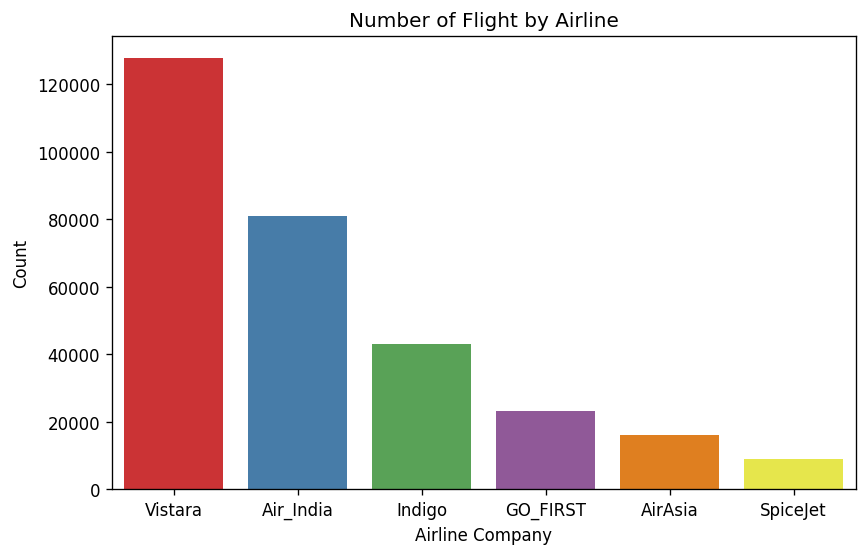

In [50]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df_pandas['Airline'].value_counts(),x=df_pandas['Airline'].value_counts().index,palette = 'Set1')
plt.xlabel('Airline Company')
plt.ylabel('Count')
plt.title('Number of Flight by Airline')
plt.show()

Within a 50-day period, the Airline Vistara has the most number of Flights between the cities.<br>
StarAir and Trujet are minor Airline companies with only 61 and 41 Flights respectively. 

In [51]:
#Departure Time
df_pandas['Departure_Time'].value_counts()

Morning          75210
Evening          65416
Early_Morning    62019
Night            49483
Afternoon        46835
Late_Night        1190
Name: Departure_Time, dtype: int64

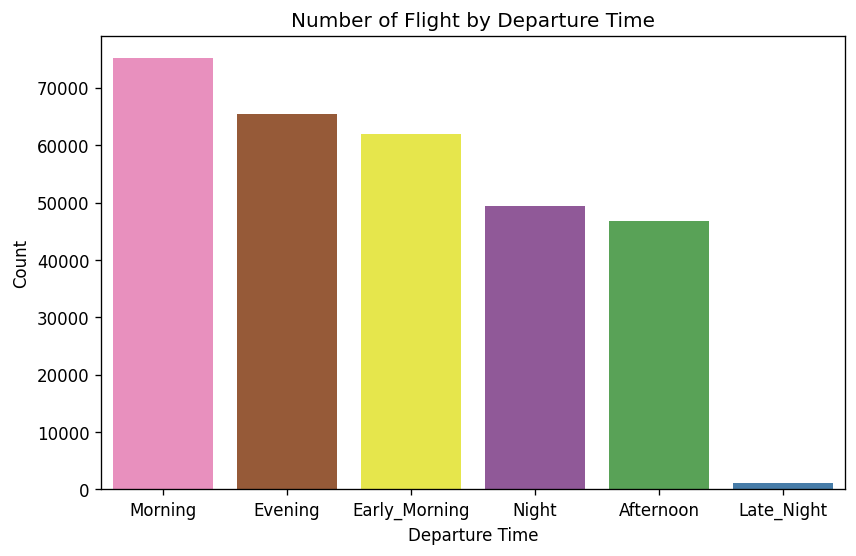

In [52]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df_pandas['Departure_Time'].value_counts(),x=df_pandas['Departure_Time'].value_counts().index,palette = 'Set1_r')
plt.xlabel('Departure Time')
plt.ylabel('Count')
plt.title('Number of Flight by Departure Time')
plt.show()

Source_City the graph it can be said that passengers do not prefer Destination_City travel at Late Night.




In [53]:
#Arrival Time
df_pandas['Arrival_Time'].value_counts()

Night            93563
Evening          77075
Morning          63735
Afternoon        37898
Late_Night       14001
Early_Morning    13881
Name: Arrival_Time, dtype: int64

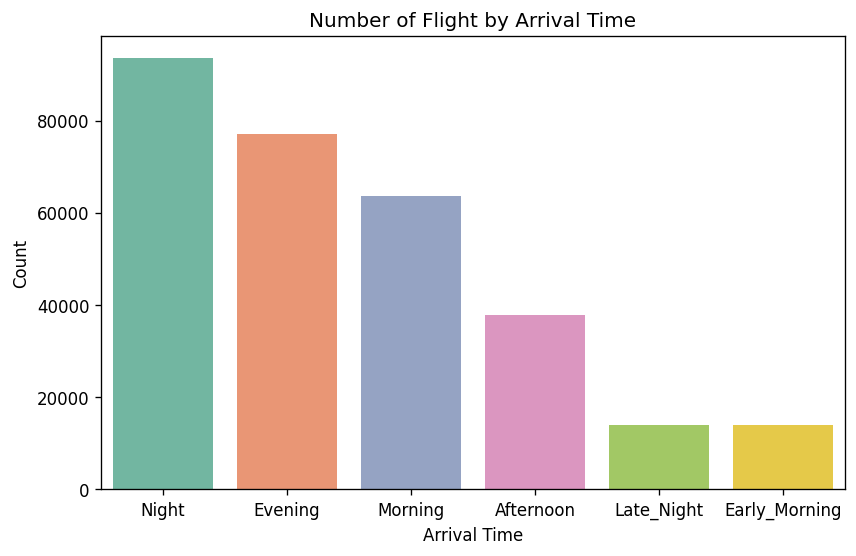

In [54]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df_pandas['Arrival_Time'].value_counts(),x=df_pandas['Arrival_Time'].value_counts().index,palette = 'Set2')
plt.xlabel('Arrival Time')
plt.ylabel('Count')
plt.title('Number of Flight by Arrival Time')
plt.show()

From the graph it can be said that passengers do not prefer to travel at Late Night.<br>Airlines may use this time for maintenance.

In [55]:
#Source City
df_pandas['Source_City'].value_counts()

Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: Source_City, dtype: int64

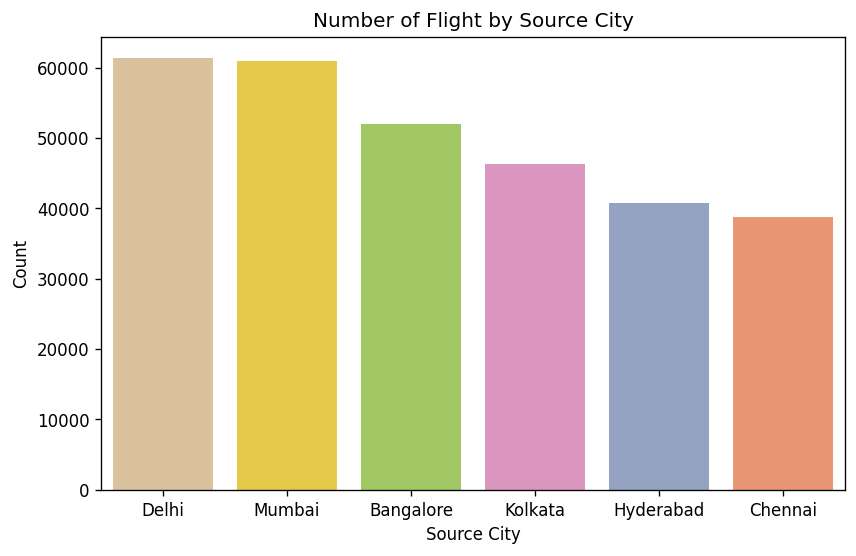

In [56]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df_pandas['Source_City'].value_counts(),x=df_pandas['Source_City'].value_counts().index,palette = 'Set2_r')
plt.xlabel('Source City')
plt.ylabel('Count')
plt.title('Number of Flight by Source City')
plt.show()

Large number of Flight originate from Delhi and Mumbai

In [57]:
#Destination City
df_pandas['Destination_City'].value_counts()

Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: Destination_City, dtype: int64

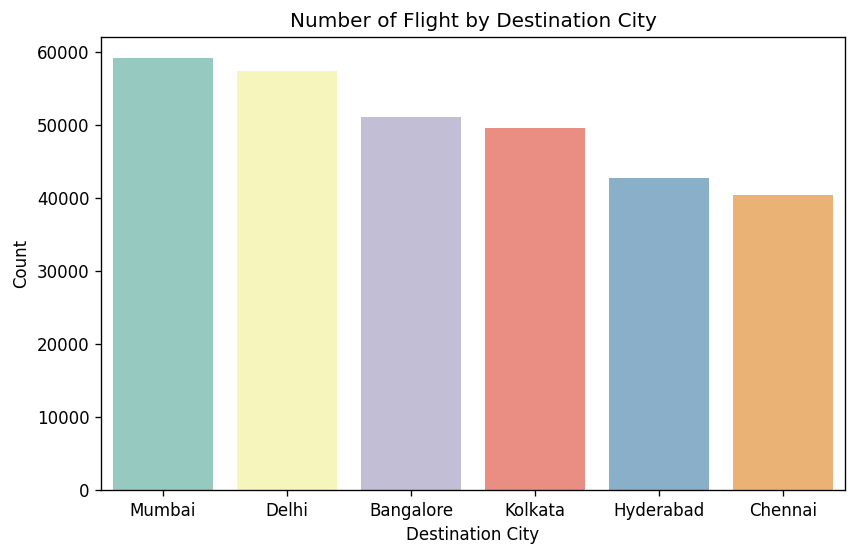

In [58]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df_pandas['Destination_City'].value_counts(),x=df_pandas['Destination_City'].value_counts().index,palette = 'Set3')
plt.xlabel('Destination City')
plt.ylabel('Count')
plt.title('Number of Flight by Destination City')
plt.show()

According to the graphs above, Delhi and Mumbai have the busiest airports, while Chennai has the least. 

In [59]:
#Number of Stop
df_pandas['Stop'].value_counts()

one            250863
zero            36004
two_or_more     13286
Name: Stop, dtype: int64

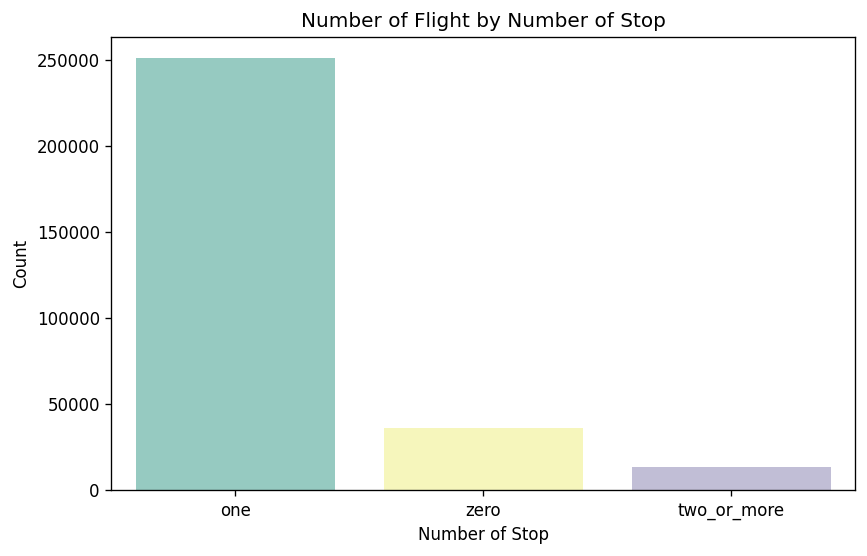

In [60]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df_pandas['Stop'].value_counts(),x=df_pandas['Stop'].value_counts().index,palette = 'Set3')
plt.xlabel('Number of Stop')
plt.ylabel('Count')
plt.title('Number of Flight by Number of Stop')
plt.show()

Between the origin and destination cities, most Flights make at least one Stop. 

In [61]:
#Class
df_pandas['Class'].value_counts()

Economy     206666
Business     93487
Name: Class, dtype: int64

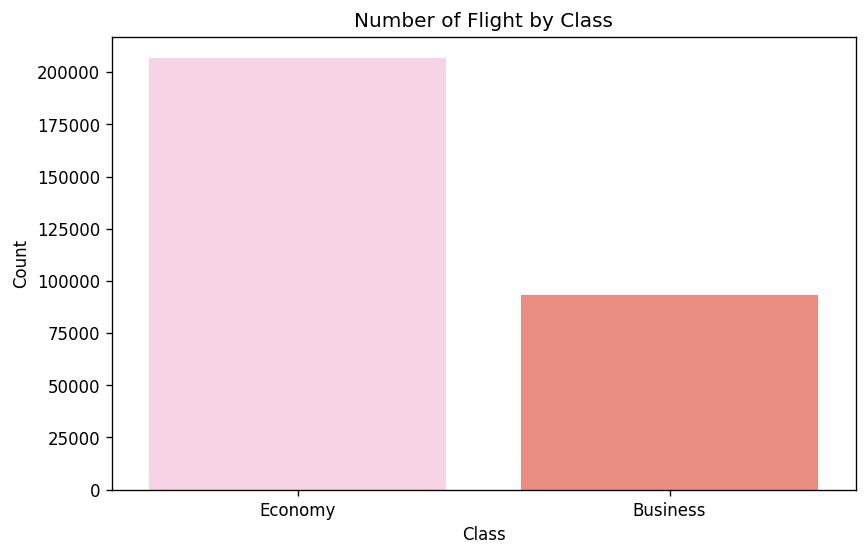

In [62]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = df_pandas['Class'].value_counts(),x=df_pandas['Class'].value_counts().index,palette = 'Set3_r')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Flight by Class')
plt.show()

In India, the majority of travel is done in economy Class. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


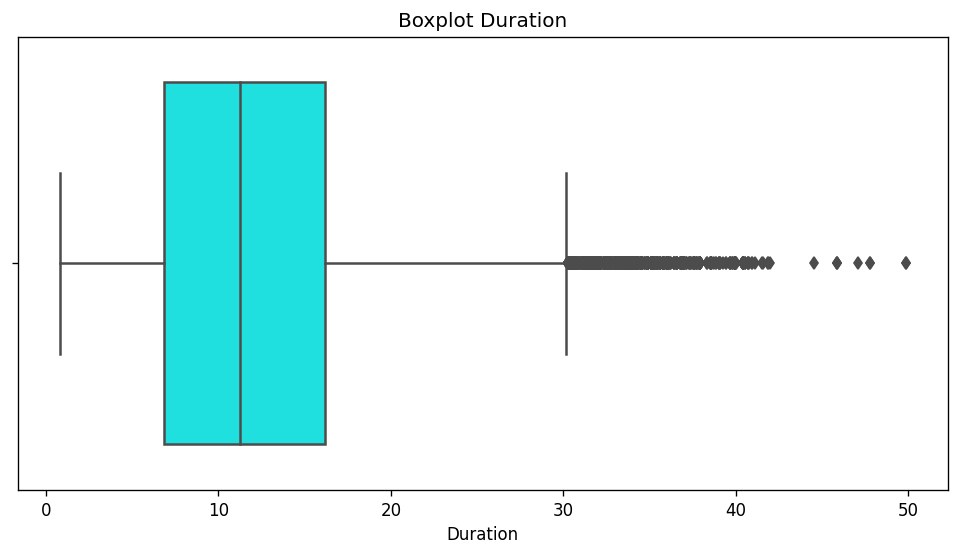

In [63]:
#Duration
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(df_pandas['Duration'],color='cyan')
plt.xlabel('Duration')
plt.title('Boxplot Duration')
plt.show()

Lots of outliers

In [64]:
#Flight
df_pandas['Flight_Code'].value_counts()

UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
6E-5003       1
G8-705        1
AI-9991       1
6E-2939       1
6E-2914       1
Name: Flight_Code, Length: 1561, dtype: int64

In [65]:
air_Flight = []
def uniq_Flight(x,data):
  global air_Flight
  air_Flight.append(df_pandas[df_pandas['Airline']==x]['Flight_Code'].nunique())

In [66]:
for air in df_pandas['Airline'].value_counts().index:
  uniq_Flight(air,df)

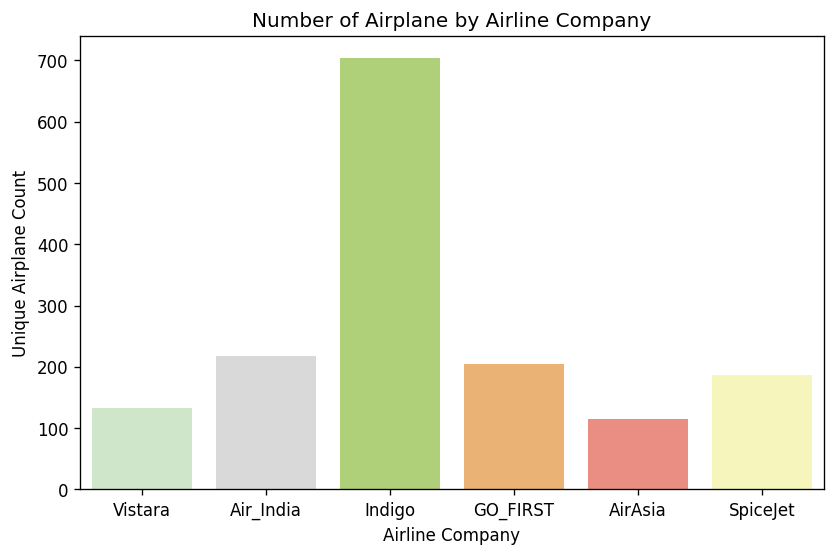

In [67]:
plt.figure(figsize=(8,5),dpi=120)
sns.barplot(y = air_Flight,x=df_pandas['Airline'].value_counts().index,palette = 'Set3_r')
plt.xlabel('Airline Company')
plt.ylabel('Unique Airplane Count')
plt.title('Number of Airplane by Airline Company')
plt.show()

Indigo has the largest number of planes that operate between cities. 

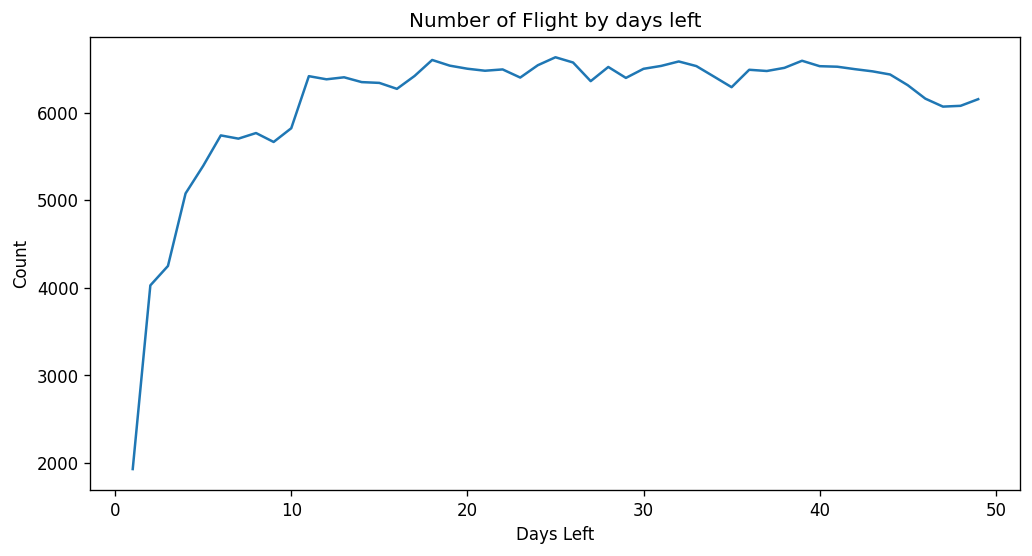

In [68]:
#Days Left
plt.figure(figsize=(10,5),dpi=120)
sns.lineplot(y=df_pandas.groupby('Days_Remaining').count()['Airline'],x=df_pandas.reset_index().groupby('Days_Remaining').count()['Airline'].index)
plt.xlabel('Days Left')
plt.ylabel('Count')
plt.title('Number of Flight by days left')
plt.show()

A recent Flight may have been booked, resulting in a lower number.
Approximately 6000 Flight booking can be done on a daily basis.

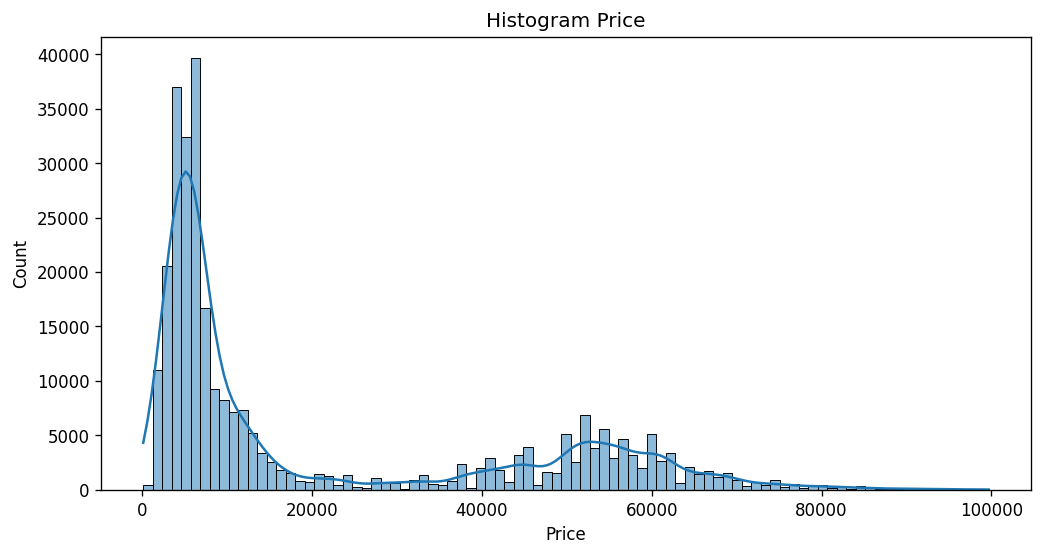

In [69]:
#Price
plt.figure(figsize=(10,5),dpi=120)
sns.histplot(df_pandas['Price'],kde=True)
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Histogram Price')
plt.show()

The graph is right skewed as expected, indicating that most passengers choose economical travel than exotic travel. 

In [70]:
df_pandas['Price'].describe()

count    300153.000000
mean      20851.787175
std       22644.373060
min         100.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max       99680.000000
Name: Price, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


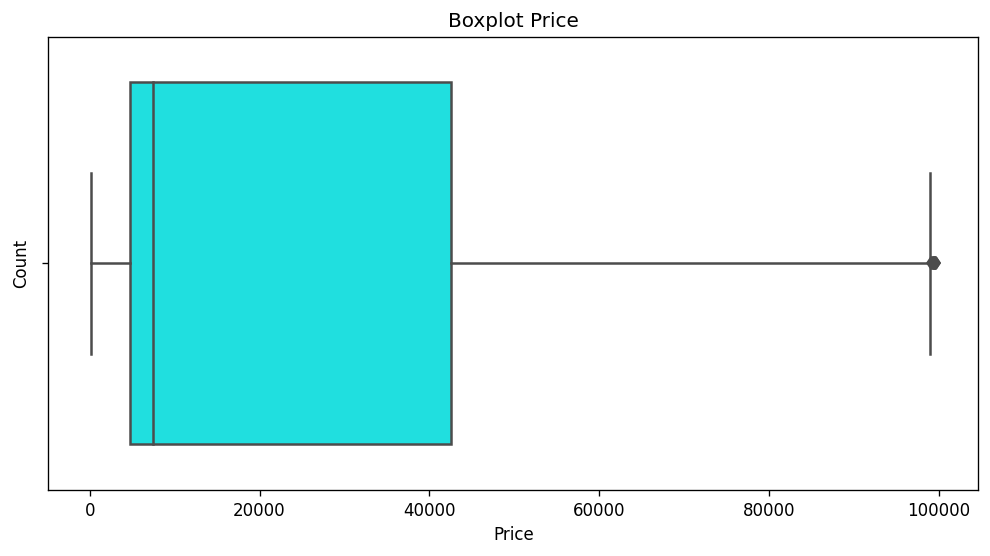

In [71]:
#Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(df_pandas['Price'],color='cyan')
plt.xlabel('Price')
plt.ylabel('Count')
plt.title('Boxplot Price')
plt.show()

In India, most Flights cost between 5000 and 40000 rupees.
With half of the Flights costing less than 7500 rupees.


## Bivariate Analysis

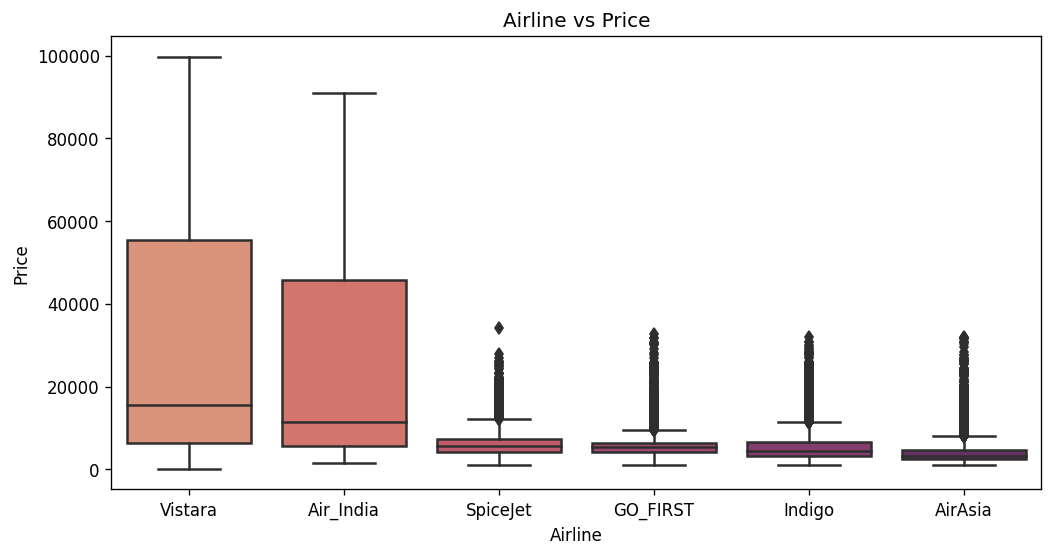

In [72]:
#Airline vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='Price',x='Airline',data = df_pandas.sort_values(by='Price',ascending=False),palette='flare')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.title('Airline vs Price')
plt.show()

We can observe Source_City the graph that Vistara and Air India have the highest Prices. Apart Source_City them, practically every Airline has a comparable median Price.

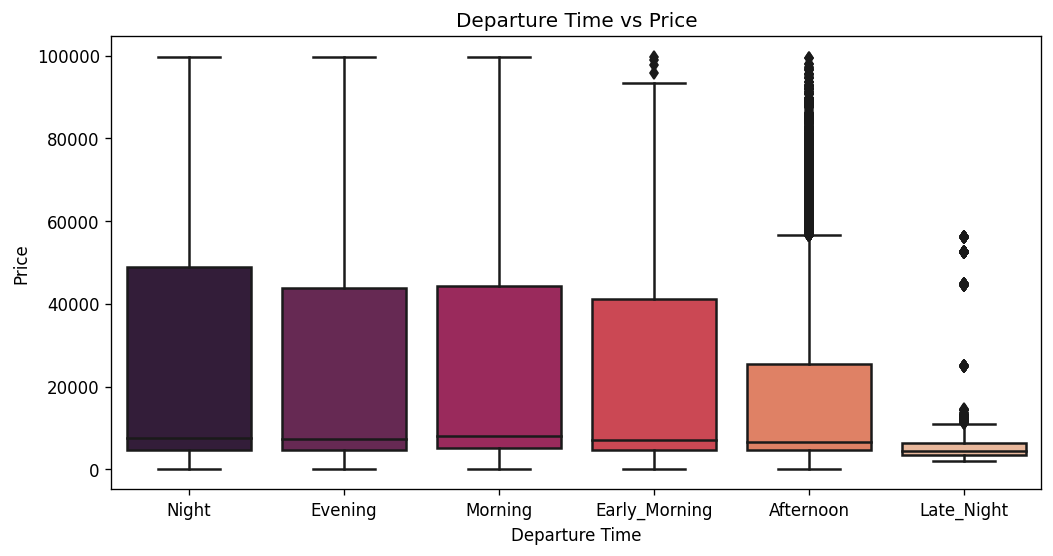

In [73]:
#Departure Time vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='Price',x='Departure_Time',data = df_pandas.sort_values(by='Price',ascending=False),palette='rocket')
plt.xlabel('Departure Time')
plt.ylabel('Price')
plt.title('Departure Time vs Price')
plt.show()

Median Price is almost the same, but the Price range for late night flights is small.

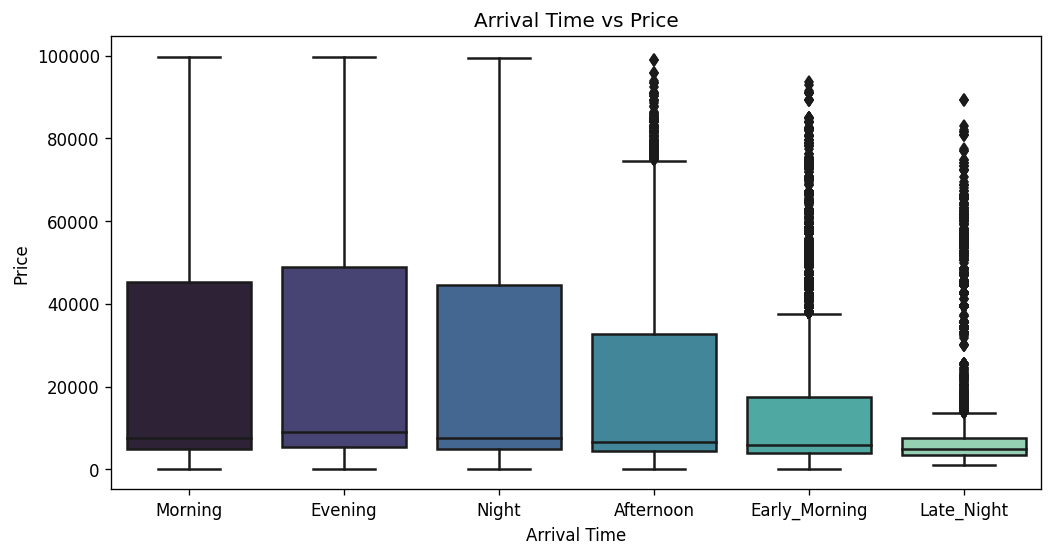

In [74]:
#Arrival Time vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='Price',x='Arrival_Time',data = df_pandas.sort_values(by='Price',ascending=False),palette='mako')
plt.xlabel('Arrival Time')
plt.ylabel('Price')
plt.title('Arrival Time vs Price')
plt.show()

Median Price is almost the same, but the Price range for late night flights is small.

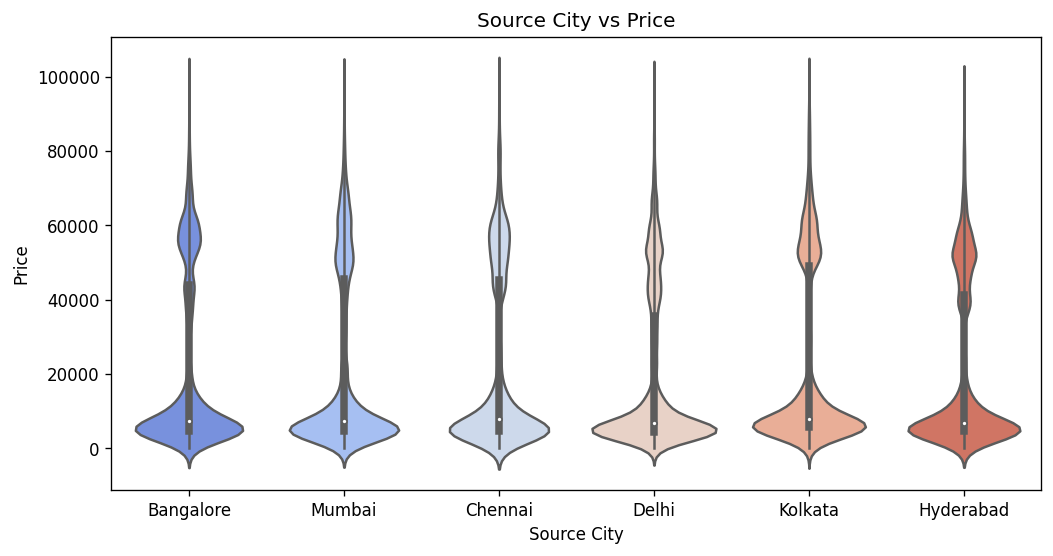

In [75]:
#Source City vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.violinplot(y='Price',x='Source_City',data = df_pandas.sort_values(by='Price',ascending=False),palette='coolwarm')
plt.xlabel('Source City')
plt.ylabel('Price')
plt.title('Source City vs Price')
plt.show()

Median Price are almost same regardless of flight source city.

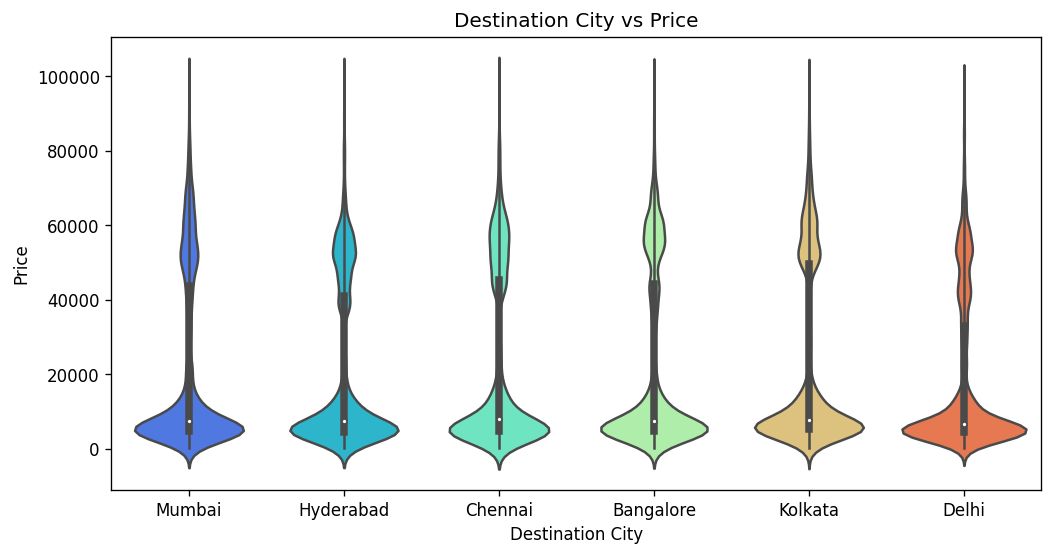

In [76]:
#Destination City vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.violinplot(y='Price',x='Destination_City',data = df_pandas.sort_values(by='Price',ascending=False),palette='rainbow')
plt.xlabel('Destination City')
plt.ylabel('Price')
plt.title('Destination City vs Price')
plt.show()

Median Price are almost same regardless of flight destination city.

<Figure size 1200x600 with 0 Axes>

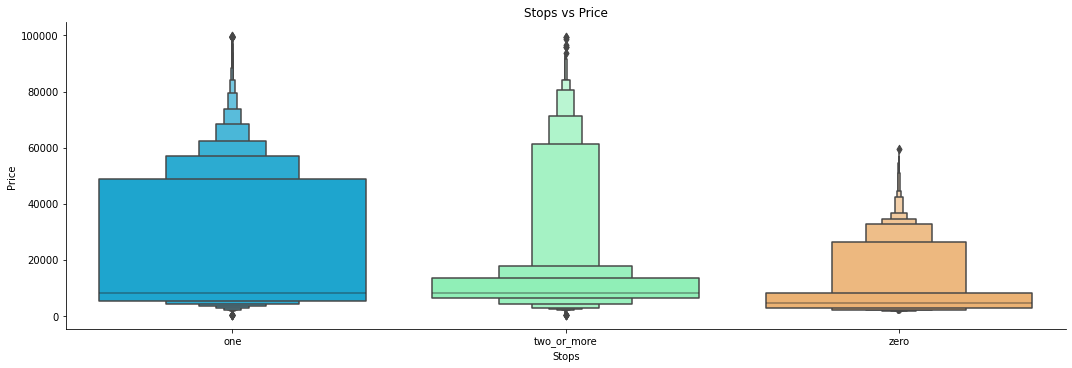

In [77]:
#Stops vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.catplot(y='Price',x='Stop',data = df_pandas.sort_values(by='Price',ascending=False),palette='rainbow',kind ='boxen',height=5,aspect=3)
plt.xlabel('Stops')
plt.ylabel('Price')
plt.title('Stops vs Price')
plt.show()

Median Price are almost same.

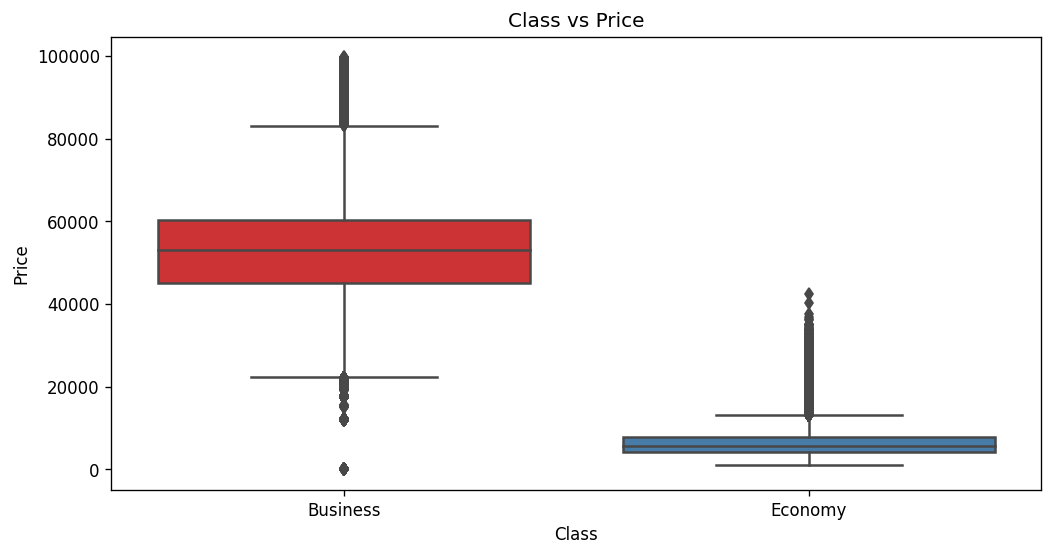

In [78]:
#Class vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='Price',x='Class',data = df_pandas.sort_values(by='Price',ascending=False),palette='Set1')
plt.xlabel('Class')
plt.ylabel('Price')
plt.title('Class vs Price')
plt.show()

Business Class flight Price is very high compared To economy Class.


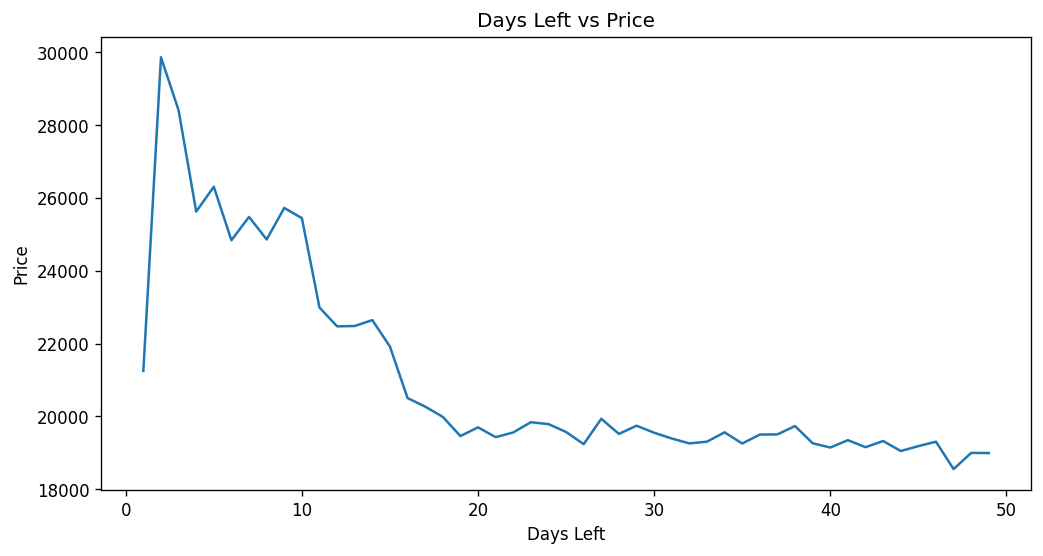

In [79]:
#Days Remaining vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.lineplot(x = df_pandas.groupby('Days_Remaining').mean().reset_index()['Days_Remaining'],y = df_pandas.groupby('Days_Remaining').mean().reset_index()['Price'])
plt.xlabel('Days Left')
plt.ylabel('Price')
plt.title('Days Left vs Price')
plt.show()



The cost of a flight fluctuates greatly depending on how early you book it.
However, after a certain amount of time, it reaches saturation. 


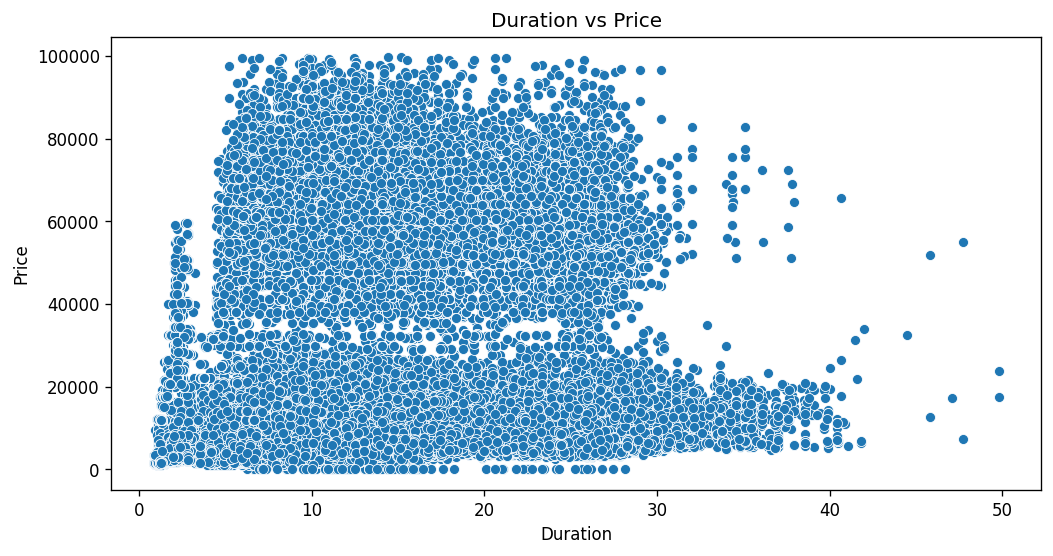

In [80]:
#Duration vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.scatterplot(y='Price',x='Duration',data = df_pandas,palette='viridis')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.title('Duration vs Price')
plt.show()

No Specific Relation

## Multivariate Analysis

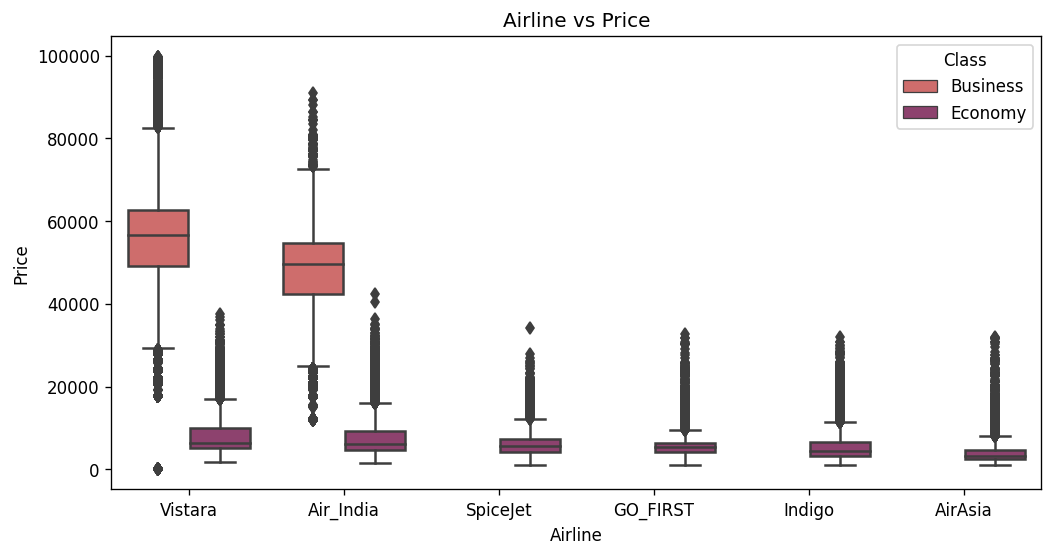

In [81]:
#Airline vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(y='Price',x='Airline',data = df_pandas.sort_values(by='Price',ascending=False),palette='flare',hue='Class')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.title('Airline vs Price')
plt.show()

In [82]:
df_pandas[df_pandas['Class']=='Business']['Airline'].value_counts()

Vistara      60589
Air_India    32898
Name: Airline, dtype: int64

In India, Business class travel is only offered by Vistara and Air India Airlines. Due to which the relative mean price of the airlines increases.

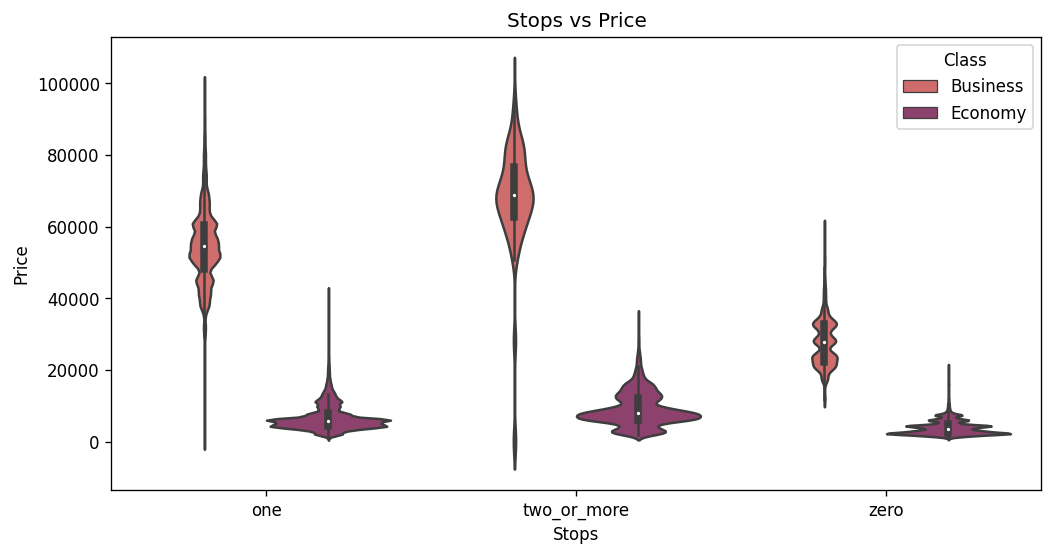

In [83]:
#Stops vs Price
plt.figure(figsize=(10,5),dpi=120)
sns.violinplot(y='Price',x='Stop',data = df_pandas.sort_values(by='Price',ascending=False),palette='flare',hue='Class')
plt.xlabel('Stops')
plt.ylabel('Price')
plt.title('Stops vs Price')
plt.show()

# Outlier Treatment

Instance of Dataset

In [84]:
df.show()

+----------+--------------+---------+-----------+-------+-----------+--------------+--------+----+-------------+----------------+-----+
|      Date|Days_Remaining|  Airline|Flight_Code|  Class|Source_City|Departure_Time|Duration|Stop| Arrival_Time|Destination_City|Price|
+----------+--------------+---------+-----------+-------+-----------+--------------+--------+----+-------------+----------------+-----+
|2022-02-12|             2|  Vistara|     UK-801|Economy|      Delhi|       Morning|   11.17| one|        Night|          Mumbai|14513|
|2022-02-14|             4|  AirAsia|     I5-784|Economy|      Delhi|       Evening|   15.17| one|Early_Morning|          Mumbai| 5949|
|2022-02-14|             4|Air_India|     AI-504|Economy|      Delhi|         Night|   11.33| one|      Morning|          Mumbai|12150|
|2022-02-16|             6|   Indigo|     6E-926|Economy|      Delhi|       Evening|    4.92| one|        Night|          Mumbai| 8885|
|2022-02-17|             7|  Vistara|     UK-835

Total number of rows

In [85]:
df.count()

300153

Price Outlier

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


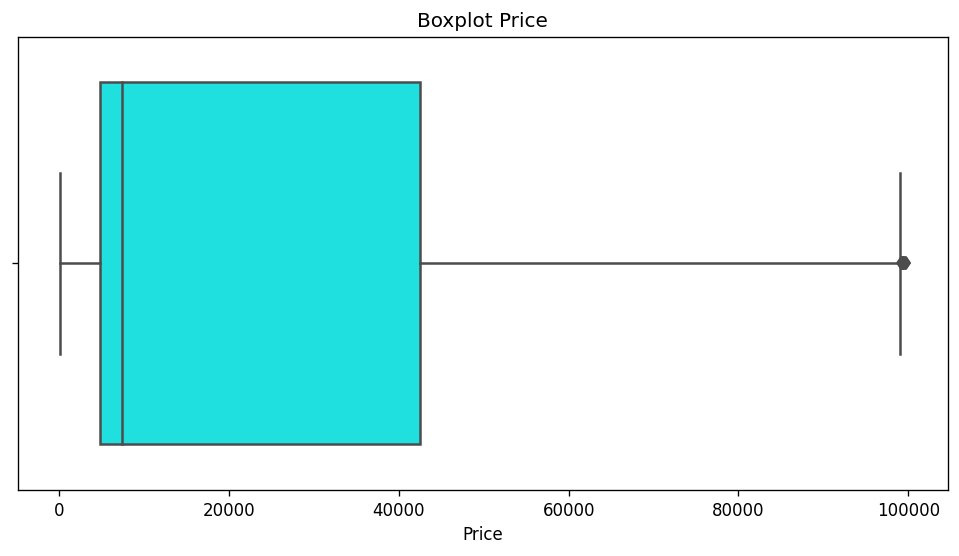

In [86]:
#Price
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(df_pandas['Price'],color='cyan')
plt.xlabel('Price')
plt.title('Boxplot Price')
plt.show()

Highly Right Skewed - Log Transformation

In [87]:
df = df.withColumn('Price',log(df['Price']))

In [88]:
#Remove Outliers
#Tried this but logarithmic result were better
'''
df_stats = df.select(mean(col('Price')).alias('mean'),stddev(col('Price')).alias('std')).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']

df = df.withColumn('z_score',(df['Price'] - mean)/std)
df = df.filter((df['z_score']<3)&(df['z_score']>-3)).drop('z_score')
'''

"\ndf_stats = df.select(mean(col('Price')).alias('mean'),stddev(col('Price')).alias('std')).collect()\n\nmean = df_stats[0]['mean']\nstd = df_stats[0]['std']\n\ndf = df.withColumn('z_score',(df['Price'] - mean)/std)\ndf = df.filter((df['z_score']<3)&(df['z_score']>-3)).drop('z_score')\n"

Duration Outlier

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


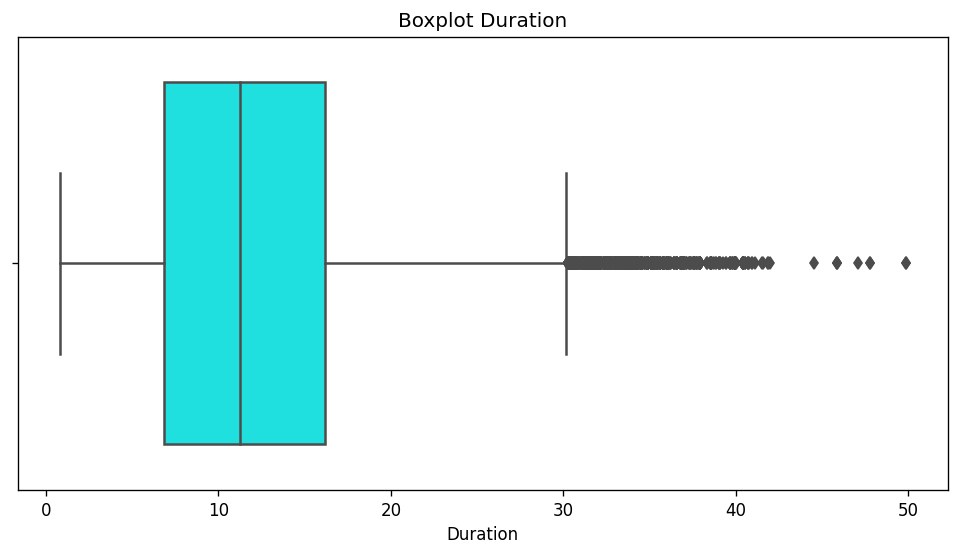

In [89]:
#Duration
plt.figure(figsize=(10,5),dpi=120)
sns.boxplot(df_pandas['Duration'],color='cyan')
plt.xlabel('Duration')
plt.title('Boxplot Duration')
plt.show()

In [90]:
df = df.withColumn('Duration',log(df['Duration']))

In [91]:
#Drop Outliers
#Tried this but logarithmic result were better
'''
duration = df.select(col('Duration')).collect()
dur = []
for x in duration:
  dur.append(float(str(x).split('=')[1].split(')')[0]))

mean = np.mean(dur)
std = np.std(dur)

df = df.withColumn('z_score',(df['Duration'] - mean)/std)
df = df.filter((df['z_score']<2.6)&(df['z_score']>-2.6)).drop('z_score')
'''

"\nduration = df.select(col('Duration')).collect()\ndur = []\nfor x in duration:\n  dur.append(float(str(x).split('=')[1].split(')')[0]))\n\nmean = np.mean(dur)\nstd = np.std(dur)\n\ndf = df.withColumn('z_score',(df['Duration'] - mean)/std)\ndf = df.filter((df['z_score']<2.6)&(df['z_score']>-2.6)).drop('z_score')\n"

#Understanding of Cleaned Dataset

DATASET<br>
Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300153 datapoints and 12 features in the cleaned dataset

FEATURES<br>
The various features of the cleaned dataset are explained below:
1. Airline: The name of the airline company is stored in the airline column. It is a categorical feature having 6 different airlines.
2. Flight: Flight stores information regarding the plane's flight code. It is a categorical feature.
3. Source City: City from which the flight takes off. It is a categorical feature having 6 unique cities.
4. Departure Time: This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
5. Stops: A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
6. Arrival Time: This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
7. Destination City: City where the flight will land. It is a categorical feature having 6 unique cities.
8. Class: A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
9. Duration: A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
10.Days Remaining: This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
11. Date: Date of travel
12. Price: Target variable stores information of the ticket price.

# Data Preprocessing

1. Only having data of 50 days, Time Series not suitable. Dropping Date Columns.
2. Flight-Code not adding anything to the model dropping it.


In [92]:
#Non -Interpretable
df = df.drop(*('Date','Flight_Code'))

In [93]:
df.printSchema()

root
 |-- Days_Remaining: integer (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Source_City: string (nullable = true)
 |-- Departure_Time: string (nullable = true)
 |-- Duration: double (nullable = true)
 |-- Stop: string (nullable = true)
 |-- Arrival_Time: string (nullable = true)
 |-- Destination_City: string (nullable = true)
 |-- Price: double (nullable = true)



##Dummy Variable Encoding

Collects the ditinct value from all the categorical features and stores it in a variable

In [94]:
airline = df.select("Airline").distinct().rdd.flatMap(lambda x: x).collect()
clas = df.select("Class").distinct().rdd.flatMap(lambda x: x).collect()
source = df.select("Source_City").distinct().rdd.flatMap(lambda x: x).collect()
departure = df.select("Departure_Time").distinct().rdd.flatMap(lambda x: x).collect()
arrival = df.select("Arrival_Time").distinct().rdd.flatMap(lambda x: x).collect()
destination = df.select("Destination_City").distinct().rdd.flatMap(lambda x: x).collect()
stop = df.select("Stop").distinct().rdd.flatMap(lambda x: x).collect()

Dummification<br>
Forming new columns for each distinct values for categorical features, where all columns have boolean 0 or 1 values.<br>With 1 denoting that the flight booked is this column type and 0 means other

In [95]:
airline_expr = [when(col("Airline") == air, 1).otherwise(0).alias("Airline_" + air) for air in airline]
class_expr = [when(col("Class") == cla, 1).otherwise(0).alias("Class_" + cla) for cla in clas]
source_expr = [when(col("Source_City") == sou, 1).otherwise(0).alias("Source_City_" + sou) for sou in source]
departure_expr = [when(col("Departure_Time") == dep, 1).otherwise(0).alias("Departure_Time_" + dep) for dep in departure]
arrival_expr = [when(col("Arrival_Time") == arr, 1).otherwise(0).alias("Arrival_Time_" + arr) for arr in arrival]
destination_expr = [when(col("Destination_City") == des, 1).otherwise(0).alias("Destination_City_" + des) for des in destination]
stop_expr = [when(col("Stop") == sto, 1).otherwise(0).alias("Stop_" + sto) for sto in stop]

In [96]:
df = df.select(*airline_expr+class_expr+source_expr+departure_expr+arrival_expr+destination_expr+stop_expr,'Days_Remaining','Duration','Price')

Dummy Trap - Dropping a column from each feature

In [97]:
df = df.drop(*('Airline_SpiceJet','Class_Business','Source_City_Hyderabad','Departure_Time_Late_Night','Arrival_Time_Late_Night','Destination_City_Hyderabad','Stop_two_or_more'))

##Creating a copy and Reloading dataset

-------This Step can be skipped, Only done to maintain a copy of data-----------

In [98]:
df.toPandas().to_csv('dataframe.csv')

In [99]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [100]:
df = spark.read.csv('/content/dataframe.csv',header = True,inferSchema = True,multiLine=True)

In [101]:
df.show()

+---+--------------+-----------------+---------------+----------------+---------------+-------------+---------------------+-------------------+------------------+-------------------+-----------------+----------------------+----------------------+------------------------+----------------------------+--------------------+--------------------+--------------------+----------------------+--------------------------+------------------+--------------------------+------------------------+-----------------------+------------------------+----------------------+--------+---------+--------------+------------------+-----------------+
|_c0|Airline_Indigo|Airline_Air_India|Airline_AirAsia|Airline_GO_FIRST|Airline_Vistara|Class_Economy|Source_City_Bangalore|Source_City_Chennai|Source_City_Mumbai|Source_City_Kolkata|Source_City_Delhi|Departure_Time_Evening|Departure_Time_Morning|Departure_Time_Afternoon|Departure_Time_Early_Morning|Departure_Time_Night|Arrival_Time_Evening|Arrival_Time_Morning|Arrival_T

##Standardisation

Scaling numerical features

In [102]:
from pyspark.ml.feature import VectorAssembler, StandardScaler 
#VectorAssembler is a transformer that combines a given list of columns into a single vector column.
#StandardScaler is used to scale the numerical data

vector_assembler = VectorAssembler(inputCols =['Days_Remaining','Duration'],outputCol = 'Vectorized_Features') #Days Remaing and Duration are the numerical variable in our model

In [103]:
standard_scaler = StandardScaler(inputCol ='Vectorized_Features',outputCol = 'Standardized_Features')  
standardised_df = standard_scaler.fit(vector_assembler.transform(df)).transform(vector_assembler.transform(df)) #Scaling

Converting Vector back to list of columns

In [104]:
columns_remain_unchanged = ['Airline_Air_India',
 'Airline_Indigo',
 'Airline_AirAsia',
 'Airline_Vistara',
 'Airline_GO_FIRST',
 'Class_Economy',
 'Source_City_Bangalore',
 'Source_City_Chennai',
 'Source_City_Mumbai',
 'Source_City_Kolkata',
 'Source_City_Delhi',
 'Departure_Time_Evening',
 'Departure_Time_Morning',
 'Departure_Time_Early_Morning',
 'Departure_Time_Afternoon',
 'Departure_Time_Night',
 'Arrival_Time_Evening',
 'Arrival_Time_Morning',
 'Arrival_Time_Afternoon',
 'Arrival_Time_Early_Morning',
 'Arrival_Time_Night',
 'Destination_City_Bangalore',
 'Destination_City_Chennai',
 'Destination_City_Mumbai',
 'Destination_City_Kolkata',
 'Destination_City_Delhi',
 'Stop_one',
 'Stop_zero',
 'Price']

In [105]:
column_changed = ['Days_Remaining','Duration']

In [106]:
def extract(row):
  return ( row.Airline_Air_India ,
          row.Airline_Indigo ,
          row.Airline_AirAsia ,
          row.Airline_Vistara ,
          row.Airline_GO_FIRST ,
          row.Class_Economy ,
          row.Source_City_Bangalore ,
          row.Source_City_Chennai ,
          row.Source_City_Mumbai ,
          row.Source_City_Kolkata ,
          row.Source_City_Delhi ,
          row.Departure_Time_Evening ,
          row.Departure_Time_Morning ,
          row.Departure_Time_Early_Morning ,
          row.Departure_Time_Afternoon ,
          row.Departure_Time_Night ,
          row.Arrival_Time_Evening,
          row.Arrival_Time_Morning,
          row.Arrival_Time_Afternoon,
          row.Arrival_Time_Early_Morning,
          row.Arrival_Time_Night,
          row.Destination_City_Bangalore ,
          row.Destination_City_Chennai ,
          row.Destination_City_Mumbai ,
          row.Destination_City_Kolkata ,
          row.Destination_City_Delhi ,
          row.Stop_one ,
          row.Stop_zero,
          row.Price,) + tuple(row.Standardized_Features.toArray().tolist()) #converts standardised vectors back to individual column

Mapping the dataset in ectract function and forming the dataframe Standardised_df

In [107]:
standardised_df = standardised_df.select(*columns_remain_unchanged, "Standardized_Features").rdd.map(extract).toDF(columns_remain_unchanged + column_changed)

Our DataFrame is ready for model building

#Model Building

In [108]:
independent_cols = ['Airline_Air_India',
 'Airline_Indigo',
 'Airline_AirAsia',
 'Airline_Vistara',
 'Airline_GO_FIRST',
 'Class_Economy',
 'Source_City_Bangalore',
 'Source_City_Chennai',
 'Source_City_Mumbai',
 'Source_City_Kolkata',
 'Source_City_Delhi',
 'Departure_Time_Evening',
 'Departure_Time_Morning',
 'Departure_Time_Early_Morning',
 'Departure_Time_Afternoon',
 'Departure_Time_Night',
 'Arrival_Time_Evening',
 'Arrival_Time_Morning',
 'Arrival_Time_Afternoon',
 'Arrival_Time_Early_Morning',
 'Arrival_Time_Night',
 'Destination_City_Bangalore',
 'Destination_City_Chennai',
 'Destination_City_Mumbai',
 'Destination_City_Kolkata',
 'Destination_City_Delhi',
 'Stop_one',
 'Stop_zero',
 'Days_Remaining',
 'Duration']
dependent_col = 'Price'  #Target

In [109]:
assembler = VectorAssembler(inputCols = independent_cols,outputCol = 'Independent')
final = assembler.transform(standardised_df).select('Independent','Price')

In [110]:
final.show(truncate = False)

+----------------------------------------------------------------------------------------------------+-----------------+
|Independent                                                                                         |Price            |
+----------------------------------------------------------------------------------------------------+-----------------+
|(30,[3,5,10,12,20,23,26,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.14748170903481847,3.280479827003534]) |9.582800078470363|
|(30,[2,5,10,11,19,23,26,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.29496341806963694,3.696567572269127]) |8.690978417187905|
|(30,[0,5,10,15,17,23,26,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.29496341806963694,3.2998134455809143])|9.405084448768694|
|(30,[1,5,10,11,20,23,26,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.4424451271044554,2.165899229970038])  |9.092119740588751|
|(30,[3,5,10,11,17,23,26,28,29],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5161859816218647,3.7475719924769253]) |9.471935109664646|
|(30,[3,5,10,13,18,23,26,28,29],

Splitting the DataFrame Randomly into Train and Test 

In [111]:
train, test = final.randomSplit([0.75,0.25])

##Linear Regression

In [112]:
#Creating an object of Linear Regression and fitting the training data
lr = LinearRegression(featuresCol = 'Independent',labelCol = 'Price').fit(train) 

In [113]:
lr.coefficients

DenseVector([0.0575, -0.1197, -0.4515, 0.1786, -0.0433, -2.0174, 0.0871, 0.0356, 0.0379, 0.2189, 0.0541, -0.0409, 0.0084, -0.0088, -0.019, -0.0416, 0.025, -0.0329, -0.0156, -0.0858, 0.0174, 0.0971, 0.0517, 0.0742, 0.1996, 0.0744, -0.2057, -0.5531, -0.1923, 0.062])

Coefficients determine how much a feature affect the price with what value

In [114]:
lr.intercept

10.947217906136638

Intercept is the log flight price when all the variables are zero.<br>
Since our Dataset has dummy values so even if all the variables are zero still the booking will have a certain range of feature

In [115]:
#predicting the values of test data
pred = lr.evaluate(test)

In [116]:
pred.predictions.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+-----------------+-----------------+
|         Independent|            Price|       prediction|
+--------------------+-----------------+-----------------+
|(30,[0,5,6,11,16,...|9.583557732534226|9.133796748430807|
|(30,[0,5,6,11,16,...|9.546955455537143|9.115006671509496|
|(30,[0,5,6,11,16,...| 9.46877384406884|8.991227568943108|
|(30,[0,5,6,11,16,...|9.116139576577355|8.934116006560963|
|(30,[0,5,6,11,16,...|8.792701462936309|8.821054755615418|
|(30,[0,5,6,11,16,...|8.792701462936309|8.792692620060802|
|(30,[0,5,6,11,16,...|8.792701462936309|8.721787281174265|
|(30,[0,5,6,11,16,...|8.792701462936309|8.622519806733113|
|(30,[0,5,6,11,16,...|9.135293497653272| 9.18119651122176|
|(30,[0,5,6,11,16,...|9.100413892597578|9.114923109704772|
|(30,[0,5,6,11,16,...|9.135293497653272|9.053566901225992|
|(30,[0,5,6,11,16,...|9.354007721788596|9.007463887160329|
|(30,[0,5,6,11,16,...|9.135293497653272| 9.01102369789407|
|(30,[0,5,6,11,16,...|9.064620717626777|8.98729349970900

Mean Absolute Error

In [117]:
pred.meanAbsoluteError

0.25649659102346956

Antilog, then evaluate will give a value of MAE as 4598<br>
So in average our prediction will be 4598 rs away from the actual value

RMSE

In [118]:
pred.rootMeanSquaredError

0.34635287504408313

R Square

In [119]:
pred.r2

0.9040108949534635

Regression Output

In [120]:
#Converting to pandas dataset
standardized_df = standardised_df.toPandas()

In [121]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [122]:
X = standardized_df.drop('Price',axis=1)
y = standardized_df['Price']

In [123]:
x = sm.add_constant(X)
model = sm.OLS(y,x).fit()
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 9.395e+04
Date:                Sat, 05 Mar 2022   Prob (F-statistic):               0.00
Time:                        14:12:18   Log-Likelihood:            -1.0739e+05
No. Observations:              300153   AIC:                         2.148e+05
Df Residuals:                  300122   BIC:                         2.152e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

Inference Drawn,
1. P-Value of F-statistics is significant saying that the at least one beta coefficient of the independent feature is nonzero and that we may go ahead to analyse the regression output.
2. R-Squared value is 0.904, saying that about 90.4% variance in target variable is explained by all the independent variables.
3. Adjusted R-Squared value is same as R-Squared, telling us that all the independent variables is adding something to explain the target variable. But this inference may not be significant as the dataset has about 3 lakh datapoints.
4. All the variable coefficient is significant as the p-Value is less than 0.05, except departure time moning and early morning

Broad Inference:<br>
Dummy Variable Inference:
1. Airlines: 
> a. When all the airline dummy variable is zero then it will give the price for the airline SpiceJet.<br>
> b. We see that the Vistara airline has the maximum coefficient (dummy intercept) of 0.174 telling us that log price goes up by a value of 0.174 as we change the airline from SpiceJet to Vistara.<br>
> c. Since the coefficient of AirAsia is most negative, it tells us that AirAsia has the minimum ticket price among all the airlines.
2. Source City:
>a. When all the source city dummy variable is zero then it will give the price for the flights from Hyderabad.<br>
>b. We see that the source city Kolkata has the maximum coefficient (dummy intercept) of 0.218 telling us that log price goes up by a value of 0.218 if the flight originates from Kolkata in place of Hyderabad.<br>
>c. Since all the coefficient are positive, telling us that flight originating from Hyderabad cost less.
3. Destination City:
>a. When all the destination city dummy variable is zero then it will give the price for the flights landing in Hyderabad.<br>
>b. We see that the Destination city Kolkata has the maximum coefficient (dummy intercept) of 0.200 telling us that log price goes up by a value of 0.200 if the flight lands in Kolkata in place of Hyderabad.<br>
>c. Since all the coefficient are positive, telling us that flight landing in Hyderabad cost less.
4. Stops:
>a. When all the stops dummy variable is zero then it will give the price for the flights with two or more stop.<br>
>b. We see that the all the coefficient is negative, telling us that flight with two or more stops are most expensive.<br>
>c. Flights with no stop has the most negative coefficient, telling us that flight having no stop cost less.
5. Departure Time:
>a. When all the Departure Time dummy variable is zero then it will give the price for the flights departing at Late Night.<br>
>b. We see that the Flights departing at late night has the maximum coefficient (dummy intercept) of 0.070 telling us that log price goes up by a value of 0. 070 if the flight departs at late night instead of Late Night.<br>
>c. Flights departing at night has the most negative coefficient, telling us that night travel is cheaper.
6. Arrival Time:
>a. When all the Arrival Time dummy variable is zero then it will give the price for the flights arriving at location in Late Night.<br>
>b. We see that the Flights arriving in Evening has the maximum coefficient (dummy intercept) of 0.023 telling us that log price goes up by a value of 0. 023 if the flight arrives at location in evening instead of Late Night.<br>
>c. Flights arriving at location in Early Morning has the most negative coefficient.
7. Class:
>a. When the Class dummy variable is zero then it will give flight price for Business Class.<br>
>b. We see that the Flights of Economy Class has a negative coefficient (dummy intercept) of -2.083 telling us that log price goes down significantly if the flight class changes from Business to Economy.<br>

Continuous Variable Inference:
1. Days Left has a negative slope, telling us that with increase in number of days between booking and travel, price goes down.<br>
2. Duration has a small positive slope, telling us that with increase in flight’s duration price goes up.


##Decision Tree Regressor

In [124]:
#Creating an object of Decision Tree Regressor and fitting the training data
dt = DecisionTreeRegressor(featuresCol ='Independent', labelCol = 'Price')
dt_model = dt.fit(train)

dt_predictions = dt_model.transform(test)

In [125]:
dt_evaluator = RegressionEvaluator(labelCol = 'Price', predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.302224


Decision Tree Result is better than Linear Regression

In [126]:
dt_model.featureImportances

SparseVector(30, {0: 0.0033, 1: 0.0066, 2: 0.0094, 3: 0.0032, 5: 0.8797, 8: 0.0, 9: 0.0004, 10: 0.0001, 18: 0.0, 19: 0.0, 22: 0.0, 23: 0.0004, 24: 0.0005, 25: 0.0, 28: 0.0619, 29: 0.0343})

##Gradient Boosting

In [127]:
#Creating an object of Gradient Tree Regressor and fitting the training data
gbt = GBTRegressor(featuresCol ='Independent', labelCol = 'Price', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)

In [128]:
gbt_predictions.select('prediction', 'Price').show(5)

+-----------------+-----------------+
|       prediction|            Price|
+-----------------+-----------------+
| 9.40683480158153|9.583557732534226|
| 9.40683480158153|9.546955455537143|
|9.382743094901116| 9.46877384406884|
| 8.62776772994403|9.116139576577355|
| 8.62776772994403|8.792701462936309|
+-----------------+-----------------+
only showing top 5 rows



In [129]:
gbt_evaluator = RegressionEvaluator(
    labelCol="Price", predictionCol="prediction", metricName="rmse")

rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.276855


Better than Linear Regression and Decision Tree

##Random Forest Regressor

In [130]:
#Creating an object of Random Forest Regressor and fitting the training data
rf = RandomForestRegressor(labelCol="Price", featuresCol="Independent")

In [131]:
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)

In [132]:
rf_predictions.select('prediction', 'Price').show(5)

+-----------------+-----------------+
|       prediction|            Price|
+-----------------+-----------------+
|9.254904866028943|9.583557732534226|
|9.206020722446814|9.546955455537143|
|9.206020722446814| 9.46877384406884|
|  8.7130256780104|9.116139576577355|
|  8.7130256780104|8.792701462936309|
+-----------------+-----------------+
only showing top 5 rows



In [133]:
rf_evaluator = RegressionEvaluator(
    labelCol="Price", predictionCol="prediction", metricName="rmse")

In [134]:
rmse = rf_evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 0.330153


Worst out of all, this is because random forest works best when the number of trees is huge and the trees generated have low bias (full grown or higher depth) but by default pyspark random forest generates only 10 trees. 

##Hypertuning Random Forest Regressor

Takes lot of time to execute causes server to disconnect(sparkcontext shutsdown)<br>So, taking a sample of the data and then optimising

Taking sample of 2% of the data and splitting it into train and test

In [135]:
sample = final.sample(withReplacement=False,fraction=0.02)
train_sample, test_sample = sample.randomSplit([0.75,0.25])

Loading the libraries

In [136]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [137]:
#instance of Random Forest Regressor
rf = RandomForestRegressor(labelCol="Price", featuresCol="Independent")

#Defining Pipeline as our train set is already vectorized so only adding rf
pipeline = Pipeline(stages=[rf])

#Defining the hyperparameters for random forest
paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [500]) \
    .addGrid(rf.bootstrap, [True])\
    .addGrid(rf.maxDepth, [10])\
    .build() 
#Tuning of the parameter was done inorder to find the optimal parameters
#Only the values for best model was assigned to save time


#3-Fold Cross Validation with rmse
crossval = CrossValidator(estimator=pipeline,estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="Price", predictionCol="prediction"),
                          numFolds=3) 

#fitting crossval model
cvModel = crossval.fit(train_sample)

In [138]:
#making predictions
predictions = cvModel.transform(test_sample)

#evaluating on test
rmse = rf_evaluator.evaluate(predictions)
print(f'RMSE : {rmse}')

RMSE : 0.23016220482333796


We see that the RMSE score improve greatly.<br>
RMSE score of as low as 0.14 can be obtained if hypertuning was done on the entire dataset.